In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

sv.config_parser.read_string("[General]\nuse_cjk_font=1")  # Sweetviz日本語化のためのフォント設定
plt.rcParams['font.family'] = ['Meiryo']  # matplotlibでグラフを作る際に日本語フォントを利用できるようにする
pd.set_option("future.no_silent_downcasting", True)  # 破壊的アップデートが予定されているため、エラーを非表示にする
JPT = 1962  # シード値

C:\Users\words\.rye\py\cpython@3.12.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 広島県民にインタビュー
【A】
- 人がやたら多い街はあるが、若い人にとって首都圏に行きづらいのは厳しいのかも
    - 福岡は飛行機で東京に行ける
    - 大阪は新幹線で東京に行ける  
- イベントをやるにも大きなキャパシティの施設が存在しない
- 市内は地価が高め
- デジタルインフラが特に進んでいるとは感じない

【B】
- 繁華街にアクセスしやすい、全体的にコンパクトな街
- 街から外れるとすぐ山で、自然に恵まれている
- 物価が高くない　広島の家賃5万と東京の家賃5万では広さが違う
- 新幹線で東京まで4時間、空港が遠い
- アーティストのツアーから外されることも多い
- 広島に住むぐらいなら福岡や大阪を選ぶ気持ちは分かる
- 広島県民は熱しやすく冷めやすい県民性があり、目新しいものが好きだからずっと広島にいると飽きる？
- なにかを継ぐものがない人が多いからフットワークが軽いのかもしれない　キッカケがあればすぐ県外に行ける

## データの前処理

In [2]:
# 令和5年時点での人口(PDFのものもあるため手入力する)
hiroshima_population = 2_739_446
kamiyama_population = 4_735
ureshino_population = 24_912
obuse_population = 10_990
nanjo_population = 46_458
kamiamakusa_population = 22_607
nozawaonsen_population = 3_107
ogata_population = 2_814

In [3]:
#令和5年の人口増減数
hiroshima_increase = pd.read_csv("../data/out/hiroshima_moving.csv", header=0, index_col=0)["総計"].sum()
kamiyama_increase = pd.read_csv("../data/out/kamiyama_moving.csv", header=0, index_col=0)["総計"].sum()
ureshino_increase = pd.read_csv("../data/out/ureshino_moving.csv", header=0, index_col=0)["嬉野"].sum()
obuse_increase = pd.read_csv("../data/out/obuse_moving.csv", header=0, index_col=0)["総計"].sum()
nanjo_increase = pd.read_csv("../data/out/nanjo_moving.csv", header=0, index_col=0)["人口増減数"].sum()
kamiamakusa_increase = pd.read_csv("../data/out/kamiamakusa_moving.csv", header=0, index_col=0)["社会増減"].sum()
nozawaonsen_increase = pd.read_csv("../data/out/nozawaonsen_moving.csv", header=0, index_col=0)["総計"].sum()
ogata_increase = pd.read_csv("../data/out/ogata_moving.csv", header=0, index_col=0)["差引増減_男"].sum() + \
                 pd.read_csv("../data/out/ogata_moving.csv", header=0, index_col=0)["差引増減_女"].sum()

In [4]:
# Well-Being指数の読み込み
well_being_hiroshima = pd.read_csv(
    '../data/2023年度版(令和5年度版) Well-Being 全国調査_広島県全域（都道府県表示）_客観.csv', encoding='sjis',
    index_col=0)
well_being_kamiyama = pd.read_csv('../data/2023年度版(令和5年度版) Well-Being 全国調査_徳島県神山町_客観.csv',
                                  encoding='sjis', index_col=0)
well_being_ureshino = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_佐賀県嬉野市_客観.csv",
                                  encoding='sjis', index_col=0)
well_being_obuse = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_長野県小布施町_客観.csv",
                               encoding='sjis', index_col=0)
well_being_nanjo = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_沖縄県南城市_客観.csv",
                               encoding='sjis', index_col=0)
well_being_kamiamakusa = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_熊本県上天草市_客観.csv",
                                     encoding='sjis', index_col=0)
well_being_nozawaonsen = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_長野県野沢温泉村_客観.csv",
                                     encoding="sjis", index_col=0)
well_being_ogata = pd.read_csv("../data/2023年度版(令和5年度版) Well-Being 全国調査_秋田県大潟村_客観.csv",
                               encoding="sjis", index_col=0)

# 偏差値の列だけ表示
well_being_hiroshima.set_index("カテゴリ・評価指標", inplace=True)
well_being_hiroshima = well_being_hiroshima.T[4:5]
well_being_hiroshima.index = ["広島県"]
well_being_hiroshima["総計"] = hiroshima_increase / hiroshima_population
well_being_kamiyama.set_index("カテゴリ・評価指標", inplace=True)
well_being_kamiyama = well_being_kamiyama.T[4:5]
well_being_kamiyama.index = ["徳島県神山町"]
well_being_kamiyama["総計"] = kamiyama_increase / kamiyama_population
well_being_ureshino.set_index("カテゴリ・評価指標", inplace=True)
well_being_ureshino = well_being_ureshino.T[4:5]
well_being_ureshino.index = ["佐賀県嬉野市"]
well_being_ureshino["総計"] = ureshino_increase /ureshino_population
well_being_obuse.set_index("カテゴリ・評価指標", inplace=True)
well_being_obuse = well_being_obuse.T[4:5]
well_being_obuse.index = ["長野県小布施町"]
well_being_obuse["総計"] = obuse_increase / obuse_population
well_being_nanjo.set_index("カテゴリ・評価指標", inplace=True)
well_being_nanjo = well_being_nanjo.T[4:5]
well_being_nanjo.index = ["沖縄県南城市"]
well_being_nanjo["総計"] = nanjo_increase /nanjo_population
well_being_kamiamakusa.set_index("カテゴリ・評価指標", inplace=True)
well_being_kamiamakusa = well_being_kamiamakusa.T[4:5]
well_being_kamiamakusa.index = ["熊本県上天草市"]
well_being_kamiamakusa["総計"] = kamiamakusa_increase / kamiamakusa_population
well_being_nozawaonsen.set_index("カテゴリ・評価指標", inplace=True)
well_being_nozawaonsen = well_being_nozawaonsen.T[4:5]
well_being_nozawaonsen.index = ["長野県野沢温泉村"]
well_being_nozawaonsen["総計"] = nozawaonsen_increase / nozawaonsen_population
well_being_ogata.set_index("カテゴリ・評価指標", inplace=True)
well_being_ogata = well_being_ogata.T[4:5]
well_being_ogata.index = ["秋田県大潟村"]
well_being_ogata["総計"] = ogata_increase / ogata_population


In [5]:
# Well-Being指数の結合
well_beings = pd.concat([
    well_being_hiroshima,
    well_being_kamiyama,
    well_being_ureshino,
    well_being_obuse,
    well_being_nanjo,
    well_being_kamiamakusa,
    well_being_nozawaonsen,
    well_being_ogata
])

In [41]:
new_column = pd.DataFrame({"増加フラグ": (well_beings["総計"] > 0)})
well_beings = pd.concat([well_beings, new_column], axis=1)
well_beings = well_beings.astype(np.float64)


## 相関分析

In [42]:
# 目的変数と説明変数の分割
# 欠損値を持つ行を除外
well_beings_clean = well_beings.dropna(subset=["総計"])
X = well_beings_clean.drop(columns=["総計"])
y = well_beings_clean["総計"]

# 欠損値は偏差値を30.0とする
filled_value = 30.0
X_filled = X.fillna(filled_value)

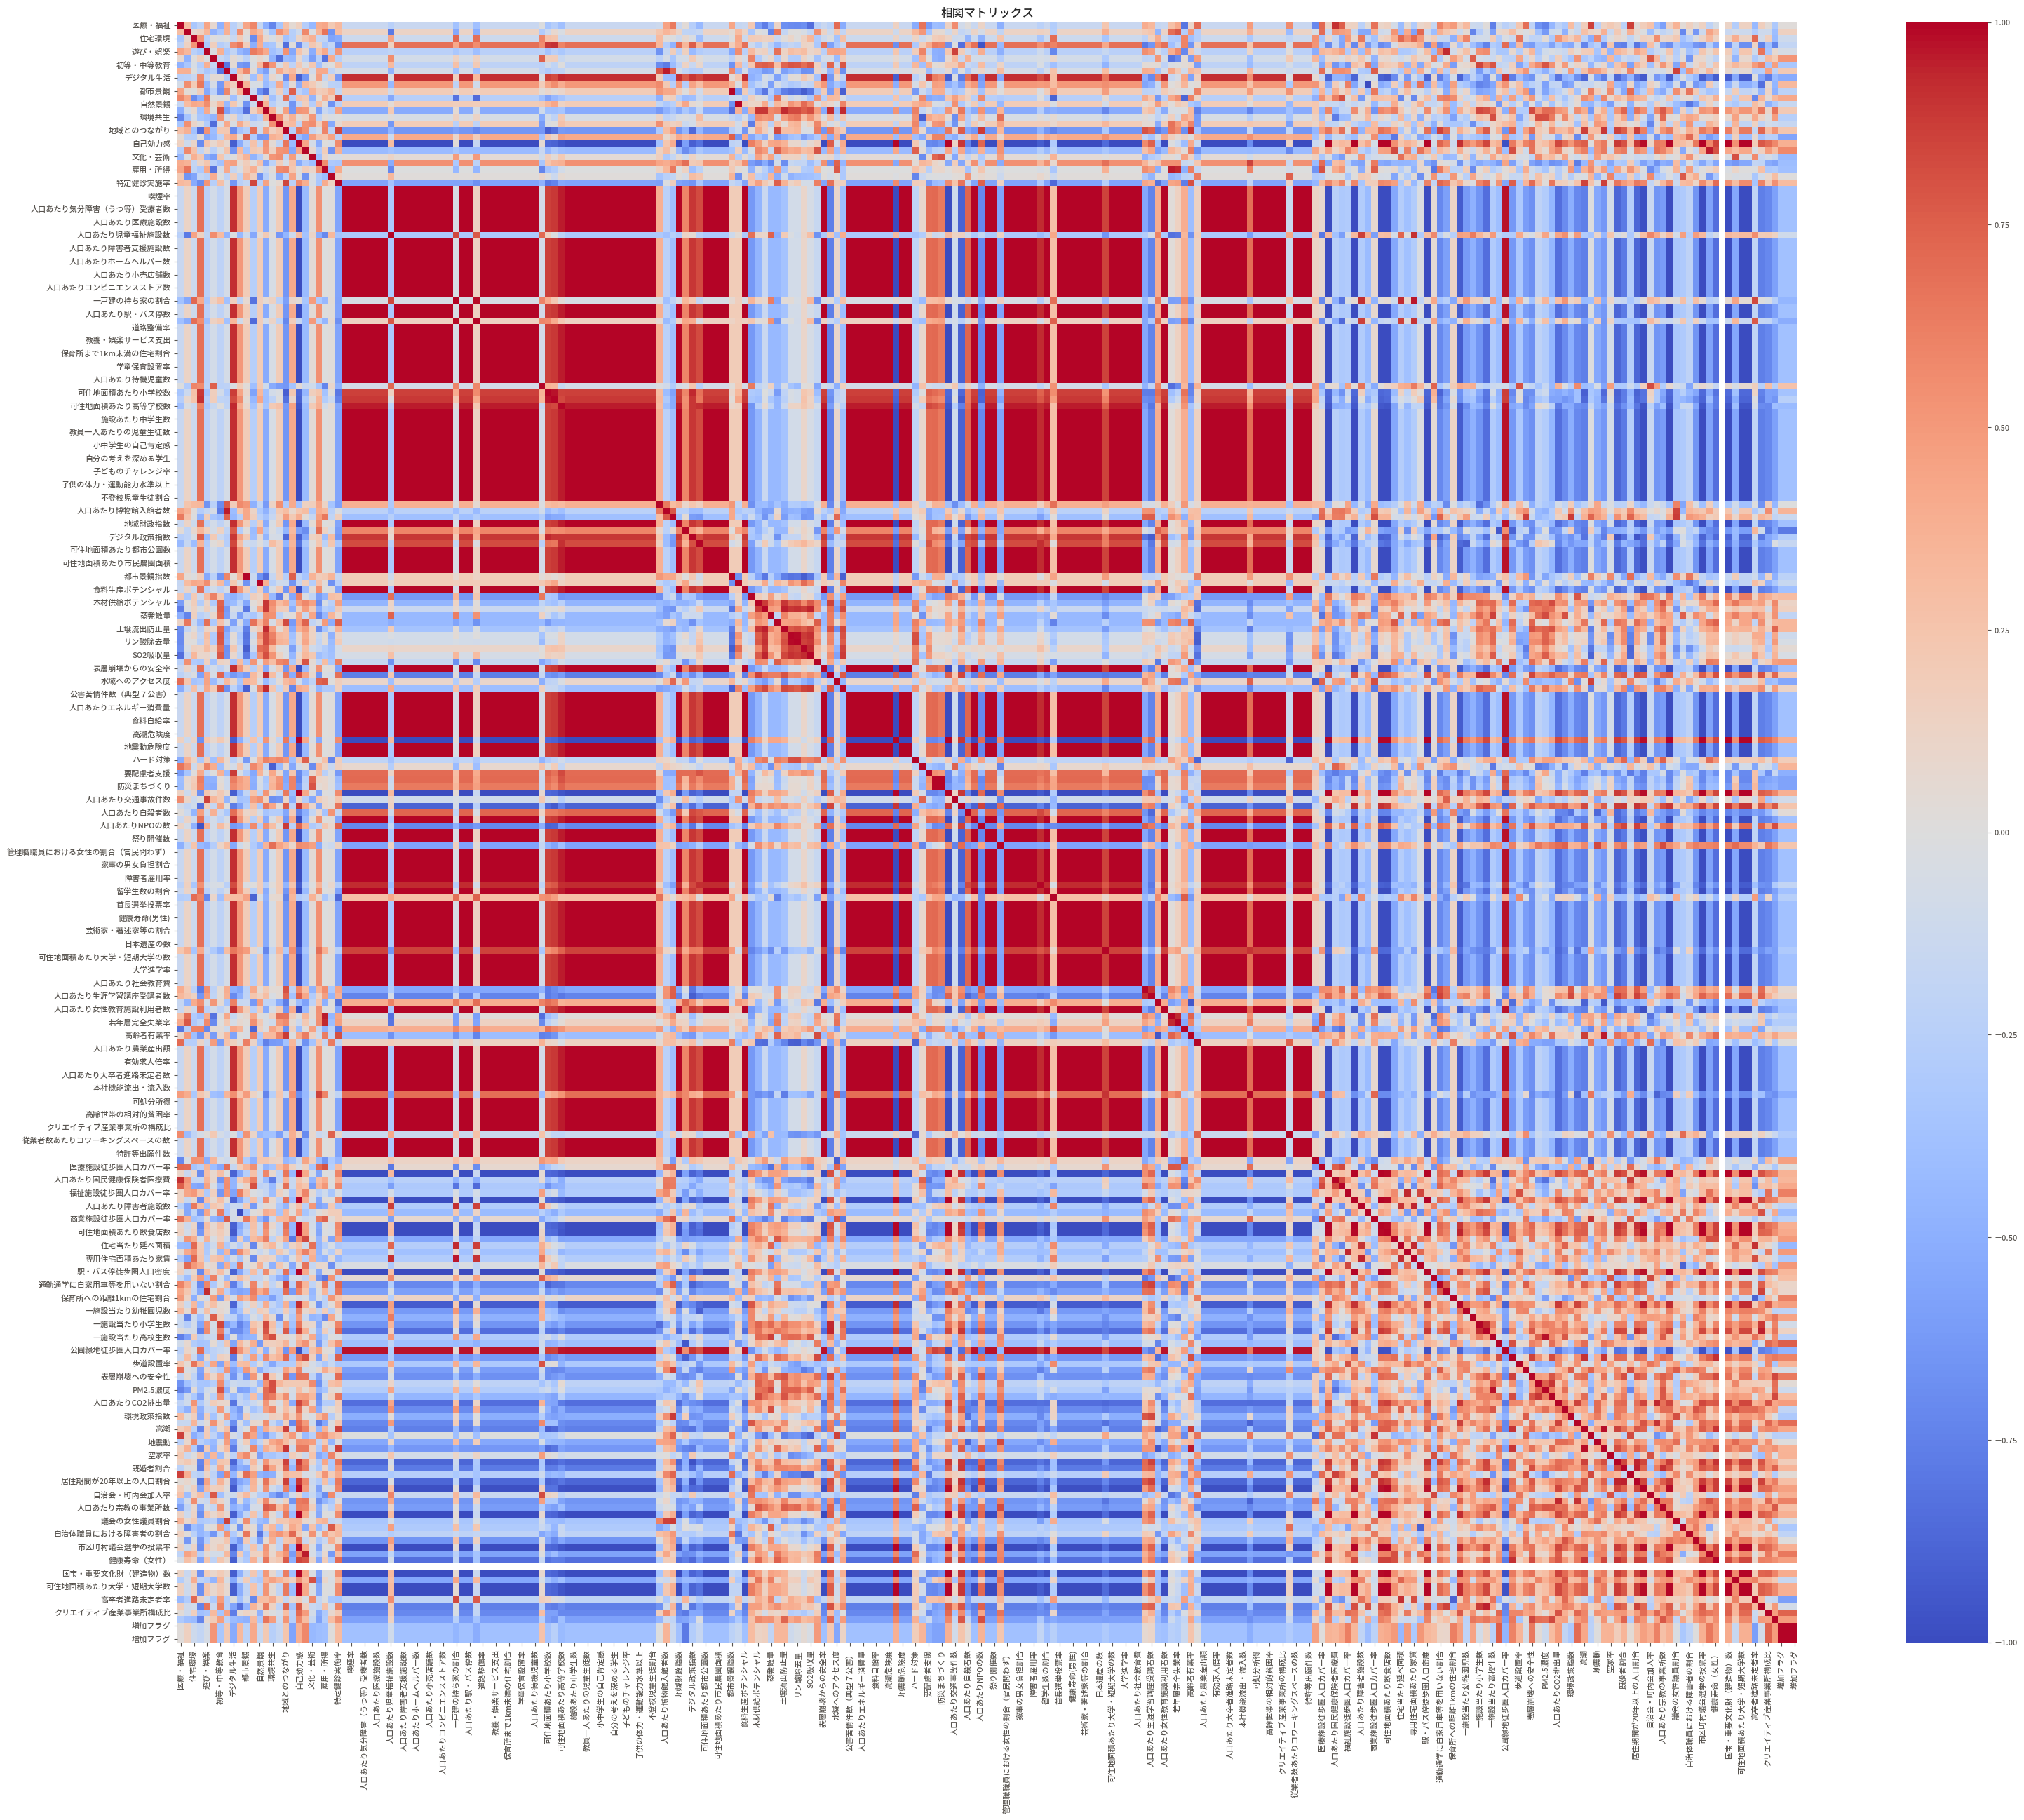

In [43]:
corr = well_beings_clean.fillna(filled_value)
corr = corr.infer_objects(copy=False)
corr_matrix = corr.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("相関マトリックス")
plt.savefig("../doc/pics/CorrelationMatrix.png")
plt.show()

In [44]:
corr_matrix["総計"].sort_values(ascending=False).to_csv("../data/out/順位.csv")

In [45]:
corr_matrix["総計"].sort_values(ascending=False)

総計               1.000000
正規雇用者比率          0.780617
人口あたり政治団体等の数     0.662391
住宅環境             0.538515
SO2吸収量           0.534578
                   ...   
商業施設徒歩圏人口カバー率   -0.695137
医療・福祉           -0.717825
土砂災害            -0.857202
水域へのアクセス度       -0.909991
芸術家・著述家等割合            NaN
Name: 総計, Length: 247, dtype: float64

### 相関分析から
- 正規雇用者比率を高めると正の相関
- 住宅環境・公共空間が整っていると正の相関
- 駅・バス停留所徒歩圏人口カバー率が高いと正の相関　→　職住接近
- 水域へアクセスしやすい負の相関
- 若年層完全失業率は負の相関

In [11]:
# sweetvizによるレポート生成
# 断片化の警告が出るが、sweetvizの仕様
report = sv.analyze(well_beings_clean.drop(["総計"], axis=1), target_feat="増加フラグ", pairwise_analysis="on")
report.show_html("../data/report/sweetviz_report.html")

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)                  C:\Users\words\.rye\py\cpython@3.12.2\Lib\site-packages\sweetviz\graph_associations.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dataframe[feature] = pd.Series(dtype=float)
C:\Users\words\.rye\py\cpython@3.12.2\Lib\site-packages\sweetviz\graph_associations.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dataframe[feature] = pd.Series(dtype=float)
C:\Users\words\.rye\py\cpython@3.12.2\Lib\site-packages\swee

Report ../data/report/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### EDA

Sweetvizで生成したHTMLから、欠損値の割合が多いカラム/増加フラグへの影響度が低いカラムを除去する

In [12]:
df_analysis = well_beings[
    [
        "増加フラグ",

        # 住環境
        # "移動・交通",
        # "住宅環境",
        # "買物・飲食",
        "地域とのつながり",
        "一戸建の持ち家の割合",
        "住宅当たり延べ面積",
        "職場までの平均通勤時間",
        "商業施設徒歩圏人口カバー率",
        "専用住宅面積あたり家賃",
        "駅・バス停留所徒歩圏人口カバー率",
        "通勤通学に自家用車等を用いない割合",
        "人口あたり娯楽業事業所数",

        # 医療
        # "医療・福祉",
        # "健康状態",
        "特定健診実施率",
        "医療施設徒歩圏人口カバー率",
        "福祉施設徒歩圏人口カバー率",

        # 経済
        "雇用・所得",
        "事業創造",
        "大卒・院卒者の割合",
        "完全失業率",
        "若年層完全失業率",
        "正規雇用者比率",
        "高齢者有業率",
        "創業比率",
        "新規設立法人の割合",
        "大学発ベンチャー企業数",
        "祭りの数",
        "市区町村内で従業している者の割合",
        "クリエイティブ産業事業所構成比",
        "従業者数あたりコワーキングスペース数",

        # 自己のあり方
        # "多様性と寛容性",
        # "自己効力感",
        # "文化・芸術",
        # "人口あたり自殺者数",
        "人口あたり外国人人口",
        "多様性政策指数",
        "人口あたり認知症サポーターメイト・サポーター数",

        # 教育
        "子育て",
        # "初等・中等教育",
        # "教育機会の豊かさ",
        "人口あたり待機児童数",
        "保育所への距離1kmの住宅割合",
        "可住地面積あたり小学校数",
        "可住地面積あたり中学校数",
        "可住地面積あたり高等学校数",
        "人口あたり図書館帯出者数",
        "人口あたり博物館入館者数",
        "人口あたり体育施設利用者数",
        "人口あたり生涯学習講座数",
        "人口あたり生涯学習講座受講者数",
        "人口あたり青少年教育施設利用者数",

        # 行政
        "地域行政",
        # "デジタル生活",
        # "公共空間",
        # "都市景観",
        # "事故・犯罪",
        "人口あたり児童福祉施設数",
        # "合計特殊出生率",
        # "自治体DX指数",
        "デジタル政策指数",
        "デジタル生活指数",
        "要配慮者支援",
        "人口あたり交通事故件数",
        "人口あたり刑法犯認知件数",
        "自治体における管理職の女性割合",
        "自治体職員における障害者の割合",

        # 自然
        # "自然景観",
        # "自然の恵み",
        "環境共生",
        "自然災害",
        "緑地へのアクセス度",
        "水域へのアクセス度",
        "オートキャンプ場への立地",

        # 防災
        "ハード対策",
        "避難・救助",

        # 家庭
        # "拡大家族世帯割合",
        "既婚者割合",
        # "高齢単身世帯割合",

    ]
]

In [13]:
report = sv.analyze(df_analysis, target_feat="増加フラグ", pairwise_analysis="on")
report.show_html("../data/report/sweetviz_report2.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)                    

Report ../data/report/sweetviz_report2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [48]:
df_analysis.corr()["増加フラグ"].sort_values(ascending=False)

カテゴリ・評価指標
増加フラグ                      1.000000
保育所への距離1kmの住宅割合            0.980476
クリエイティブ産業事業所構成比            0.723593
福祉施設徒歩圏人口カバー率              0.579029
駅・バス停留所徒歩圏人口カバー率           0.543262
子育て                        0.519641
祭りの数                       0.509525
人口あたり博物館入館者数               0.355095
従業者数あたりコワーキングスペース数         0.353553
避難・救助                      0.344604
特定健診実施率                    0.305950
高齢者有業率                     0.250464
人口あたり刑法犯認知件数               0.248645
地域とのつながり                   0.246162
緑地へのアクセス度                  0.222287
地域行政                       0.212728
ハード対策                      0.179688
オートキャンプ場への立地               0.131923
人口あたり生涯学習講座受講者数            0.106574
既婚者割合                      0.084191
人口あたり生涯学習講座数               0.067695
医療施設徒歩圏人口カバー率              0.045478
事業創造                       0.014865
創業比率                       0.013508
人口あたり図書館帯出者数              -0.002479
一戸建の持ち家の割合                -0.031131
人口あたり交通事故件数               -0.090702
人口あたり児童福祉施設数      

広島県は「子育て」(49.0)と「従業者数あたりコワーキングスペースの数」(47.3)の指数が低い

→　子育て環境と事業創造に弱み？

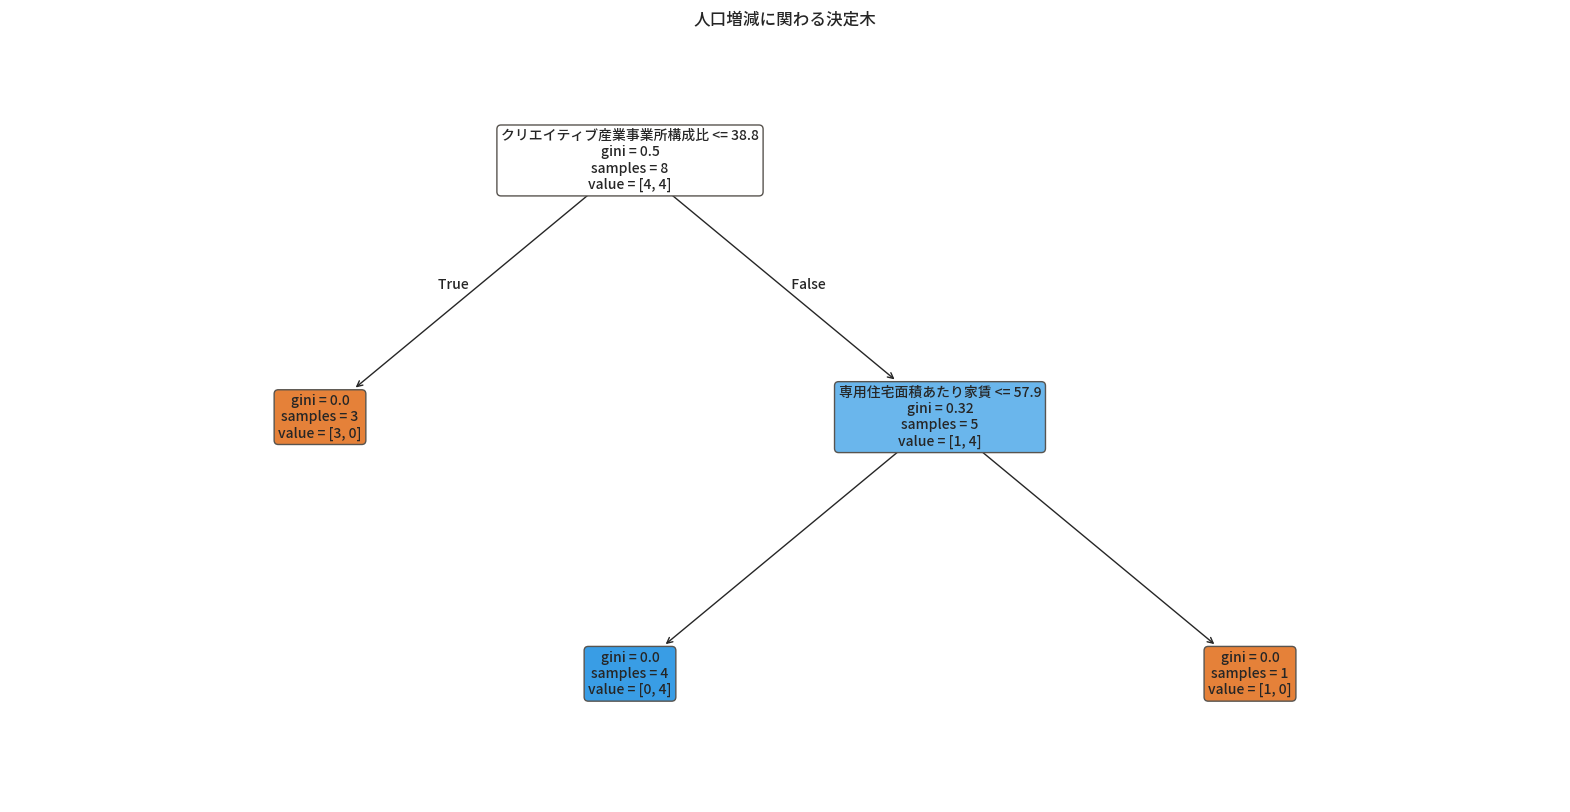

In [15]:
# 決定木回帰モデルの訓練
tree_model = DecisionTreeClassifier(random_state=JPT)
tree_model.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("人口増減に関わる決定木")
plt.savefig("../doc/pics/DecisionTreeForPopulationChange2.png")
plt.show()

In [16]:
importances = tree_model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
feature_importance

,Feature,Importance
24,クリエイティブ産業事業所構成比,0.6
5,専用住宅面積あたり家賃,0.4
0,地域とのつながり,0.0
43,デジタル政策指数,0.0
32,可住地面積あたり小学校数,0.0
33,可住地面積あたり中学校数,0.0
34,可住地面積あたり高等学校数,0.0
35,人口あたり図書館帯出者数,0.0
36,人口あたり博物館入館者数,0.0
37,人口あたり体育施設利用者数,0.0


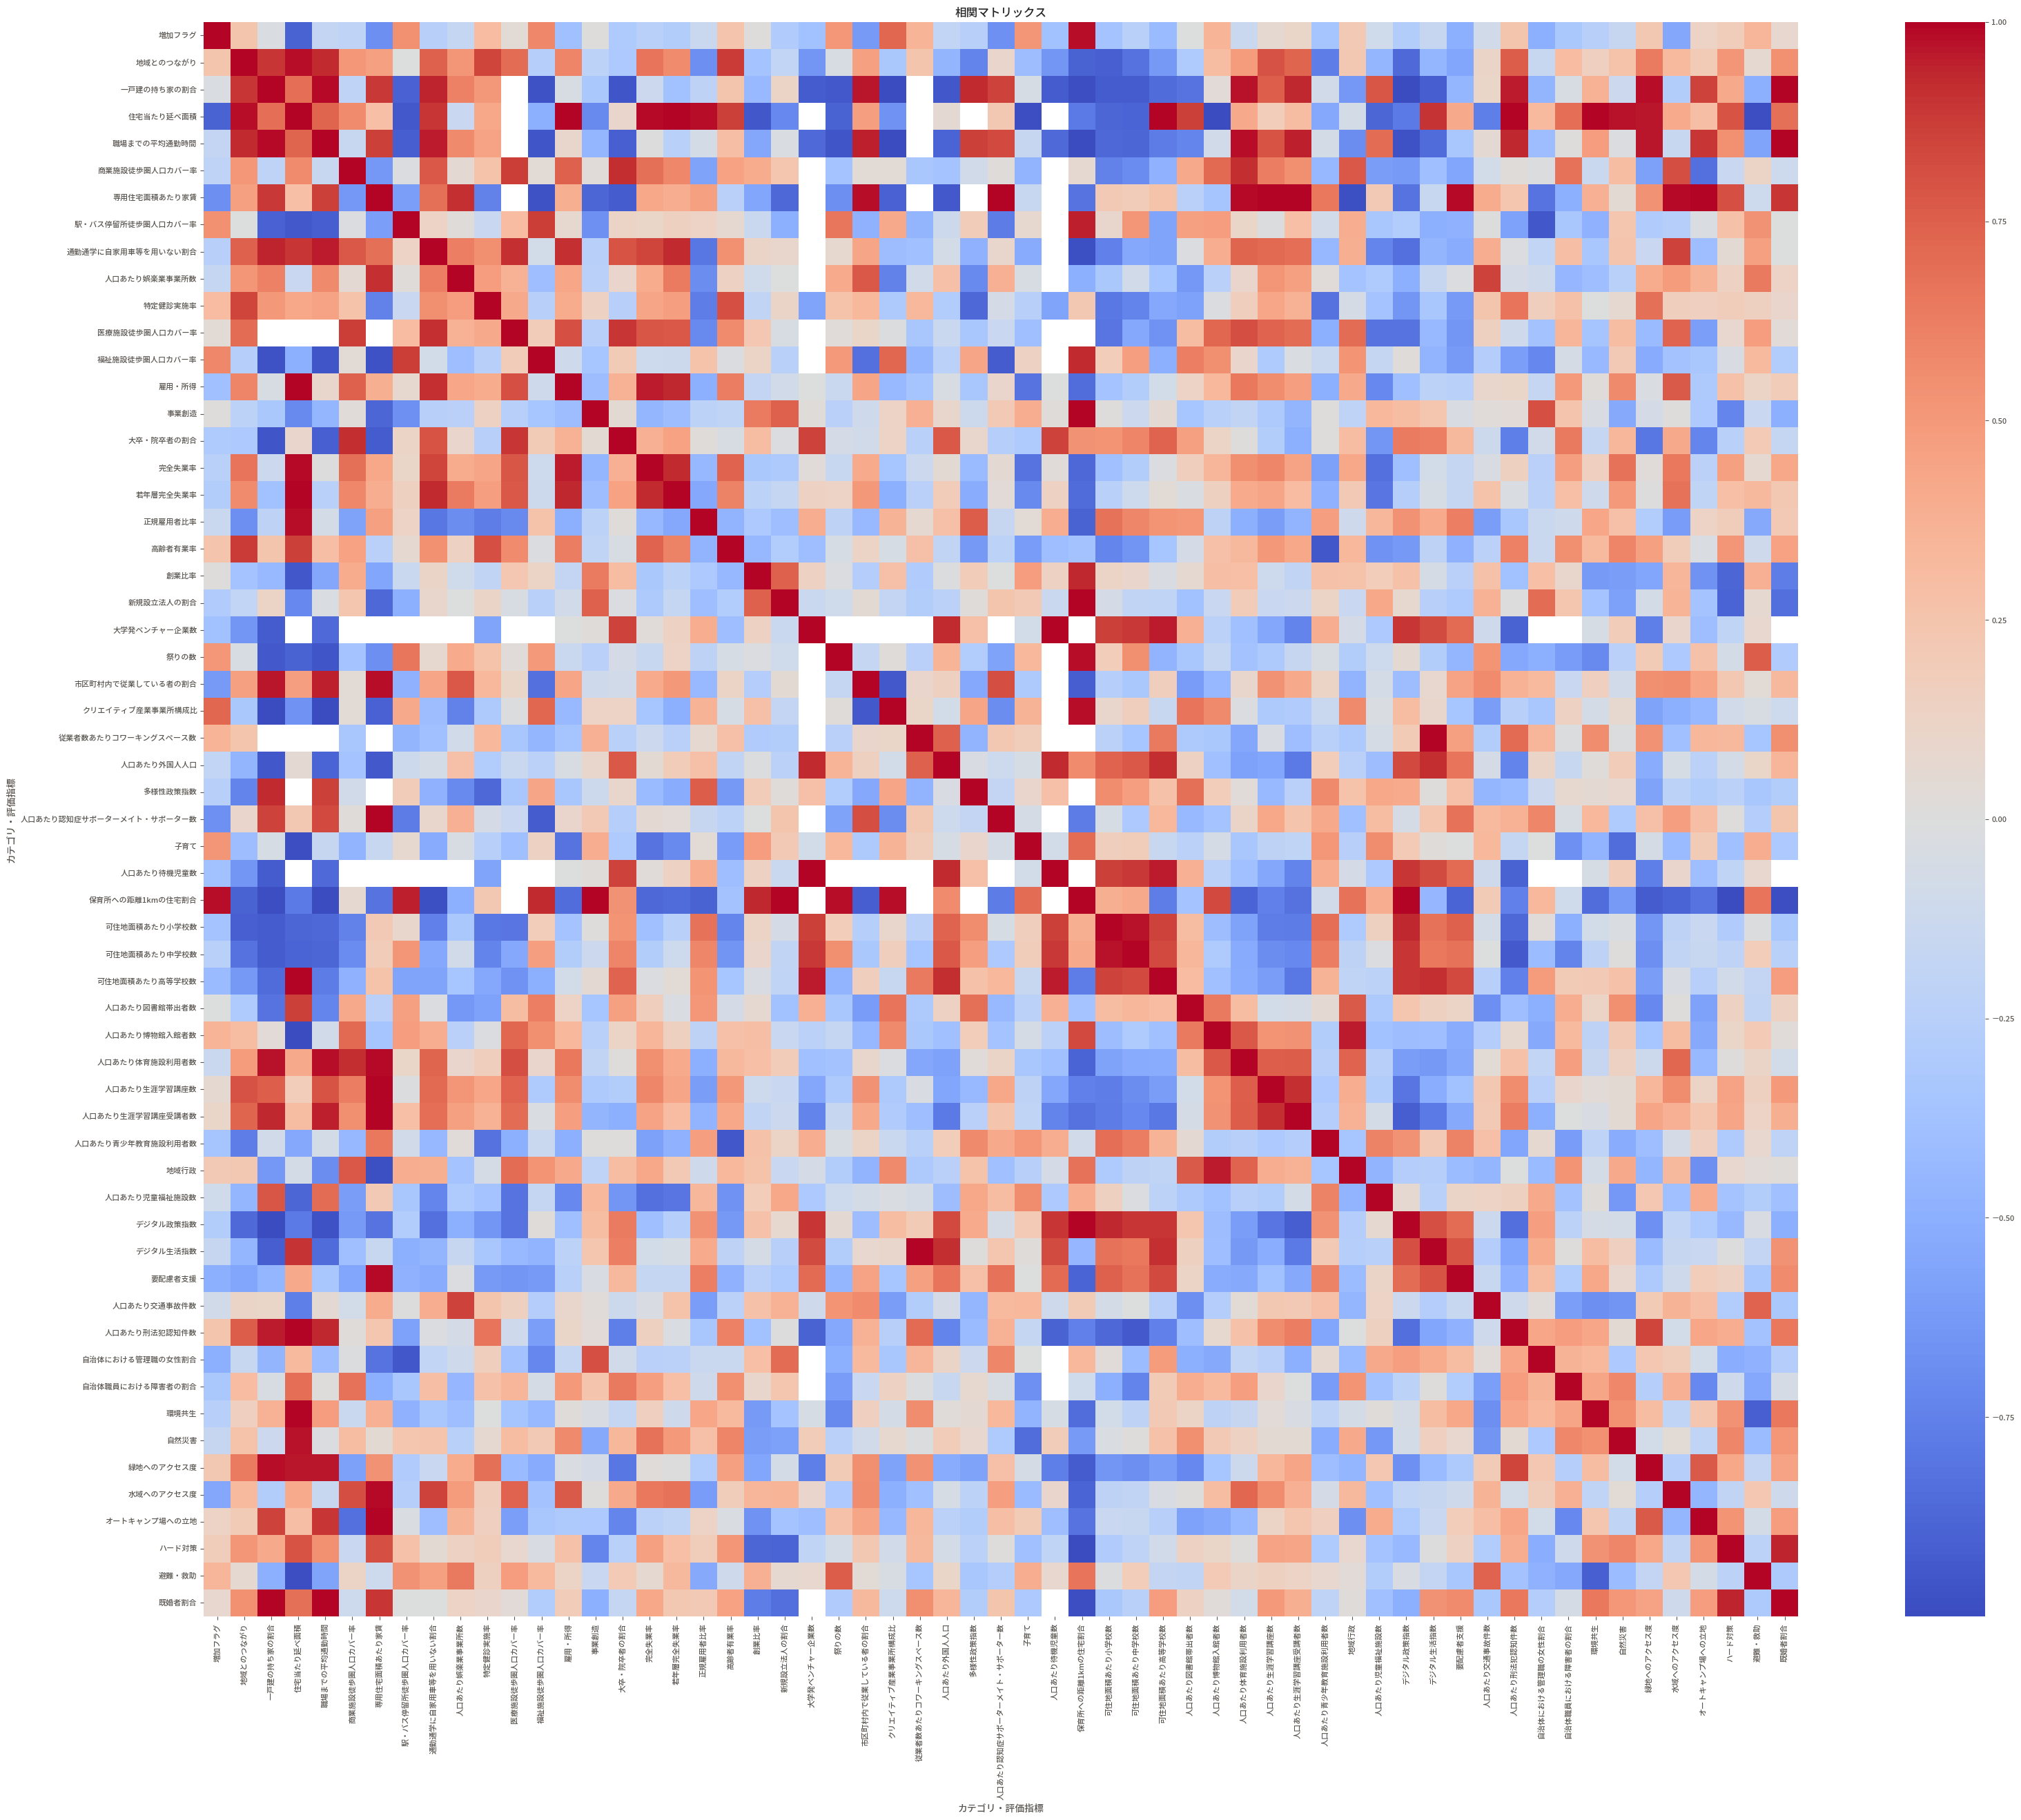

In [17]:
orr = corr.infer_objects(copy=False)
corr_matrix = df_analysis.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("相関マトリックス")
plt.savefig("../doc/pics/CorrelationMatrix2.png")
plt.show()

#### PCA

要素が多いため主成分分析を行う

In [18]:
from sklearn.preprocessing import StandardScaler

x = df_analysis.fillna(20.0)

scaler = StandardScaler()
autoscaled_X = scaler.fit_transform(x)

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
principal_components = pca.fit_transform(autoscaled_X)
pca_components = pd.DataFrame(pca.components_, columns=x.columns)

pca_components

カテゴリ・評価指標,増加フラグ,地域とのつながり,一戸建の持ち家の割合,住宅当たり延べ面積,職場までの平均通勤時間,商業施設徒歩圏人口カバー率,専用住宅面積あたり家賃,駅・バス停留所徒歩圏人口カバー率,通勤通学に自家用車等を用いない割合,人口あたり娯楽業事業所数,...,自治体における管理職の女性割合,自治体職員における障害者の割合,環境共生,自然災害,緑地へのアクセス度,水域へのアクセス度,オートキャンプ場への立地,ハード対策,避難・救助,既婚者割合
0,-0.070153,-0.199737,0.097768,0.023226,0.126811,-0.123159,0.031910,-0.079641,-0.210494,-0.171840,...,-0.069448,-0.110181,-0.007869,-0.012216,-0.147088,-0.050183,-0.048393,-0.077971,-0.015141,-0.182520
1,0.025825,-0.080335,0.196482,0.206010,0.172762,-0.148071,0.237552,-0.019498,0.034362,0.044304,...,0.151374,-0.051270,0.014384,-0.175768,0.128856,-0.151178,0.157822,-0.068268,-0.071721,0.070654
2,0.047867,-0.085856,0.014883,-0.028183,0.017695,0.171135,0.032944,0.092620,0.056031,-0.004405,...,-0.019451,0.016600,-0.291583,-0.177749,-0.187846,0.125812,-0.229251,-0.272637,0.198851,-0.137321
3,0.094605,-0.049880,0.088222,0.123943,0.078390,0.020355,0.094891,0.213067,-0.007218,-0.167327,...,-0.160706,0.098101,0.108728,0.205684,-0.074364,-0.159212,-0.049881,0.140455,-0.148506,0.080192
4,0.332472,0.009607,-0.159755,-0.195198,-0.154586,-0.182054,-0.139558,0.265581,-0.023414,0.083232,...,-0.240035,-0.281715,-0.202807,-0.093778,0.049517,-0.220565,0.151110,0.100972,0.278654,0.031688
5,0.218447,0.016382,-0.153515,-0.123333,-0.142991,0.031494,-0.145474,-0.126675,-0.048869,-0.175865,...,0.178594,0.213224,0.112241,0.013186,0.003170,-0.160345,-0.173763,-0.123392,-0.140519,-0.018571
6,0.081906,0.003351,-0.116813,-0.201184,-0.119245,0.065512,-0.094790,-0.164945,-0.051691,-0.024470,...,0.004068,-0.107470,0.132001,-0.178693,-0.122461,0.088394,0.016715,0.130940,-0.046083,0.144939
7,0.070437,-0.348620,-0.254751,0.588779,-0.460629,0.047444,-0.064424,-0.014296,0.065423,-0.160413,...,-0.034413,0.068588,0.016123,0.021922,0.037501,0.042667,-0.165690,0.053860,-0.050059,0.081878


In [20]:
contribution_threshold = 0.15

# PCAの成分を絶対値でフィルタリングし、閾値以上の値をTrueとする
significant_contributions = np.abs(pca.components_) >= contribution_threshold

# 対応する特徴量を抽出
significant_features = {}
for i, contributions in enumerate(significant_contributions):
    significant_features[f"PC{i+1}"] = x.columns[contributions].tolist()
    
significant_features

{'PC1': ['地域とのつながり',
  '通勤通学に自家用車等を用いない割合',
  '人口あたり娯楽業事業所数',
  '特定健診実施率',
  '高齢者有業率',
  '大学発ベンチャー企業数',
  '祭りの数',
  '市区町村内で従業している者の割合',
  'クリエイティブ産業事業所構成比',
  '人口あたり外国人人口',
  '人口あたり待機児童数',
  '可住地面積あたり小学校数',
  '可住地面積あたり中学校数',
  '可住地面積あたり高等学校数',
  '人口あたり生涯学習講座数',
  '人口あたり生涯学習講座受講者数',
  'デジタル政策指数',
  'デジタル生活指数',
  '要配慮者支援',
  '人口あたり刑法犯認知件数',
  '既婚者割合'],
 'PC2': ['一戸建の持ち家の割合',
  '住宅当たり延べ面積',
  '職場までの平均通勤時間',
  '専用住宅面積あたり家賃',
  '医療施設徒歩圏人口カバー率',
  '雇用・所得',
  '大卒・院卒者の割合',
  '完全失業率',
  '若年層完全失業率',
  '子育て',
  '保育所への距離1kmの住宅割合',
  '地域行政',
  '人口あたり児童福祉施設数',
  '自治体における管理職の女性割合',
  '自然災害',
  '水域へのアクセス度',
  'オートキャンプ場への立地'],
 'PC3': ['商業施設徒歩圏人口カバー率',
  '福祉施設徒歩圏人口カバー率',
  '創業比率',
  '新規設立法人の割合',
  '保育所への距離1kmの住宅割合',
  '人口あたり博物館入館者数',
  '人口あたり体育施設利用者数',
  '地域行政',
  'デジタル生活指数',
  '要配慮者支援',
  '環境共生',
  '自然災害',
  '緑地へのアクセス度',
  'オートキャンプ場への立地',
  'ハード対策',
  '避難・救助'],
 'PC4': ['駅・バス停留所徒歩圏人口カバー率',
  '人口あたり娯楽業事業所数',
  '特定健診実施率',
  '福祉施設徒歩圏人口カバー率',
  '事業創造',
  '正規雇用者比率',
  '新規設立法人の割合',
  'クリエイティブ産業事業所構成比',
  '多

In [21]:
score = pd.DataFrame(pca.transform(autoscaled_X), index=x.index)
score.to_csv("../data/out/pca.csv")
score

,0,1,2,3,4,5,6,7
広島県,10.647054,-4.363815,-0.355358,-0.856257,-0.045384,-0.157784,0.087799,2.772104e-16
徳島県神山町,-1.701214,1.383240,-4.238439,-1.439008,1.047191,3.227304,1.596879,9.059296e-16
佐賀県嬉野市,-0.088096,1.821927,-2.248345,2.449064,-3.341266,0.644429,-2.529741,4.919043e-16
長野県小布施町,-3.400751,-4.010741,1.802055,4.921396,0.361022,0.372040,1.365679,-1.522180e-15
沖縄県南城市,2.431962,5.419411,4.790354,-0.158056,1.378452,1.755608,-0.311315,5.570158e-16
熊本県上天草市,0.470072,4.261300,-1.116306,0.136090,-0.878384,-4.038024,1.680217,7.362987e-16
長野県野沢温泉村,-3.307694,-1.511309,-0.987365,-0.908663,4.431194,-1.714576,-1.935021,-2.764159e-16
秋田県大潟村,-5.051333,-3.000013,2.353403,-4.144566,-2.952824,-0.088997,0.045505,-8.372405e-16


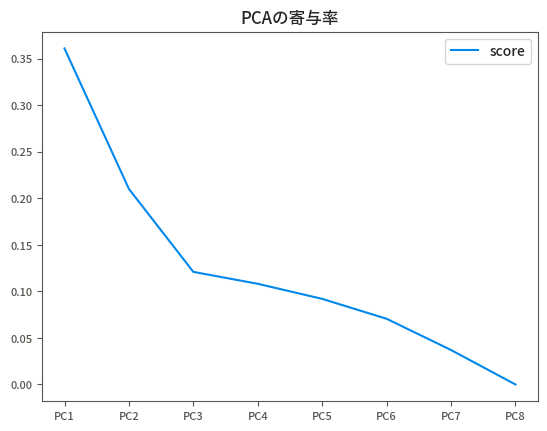

In [27]:
# 寄与率
ax = pd.DataFrame(pca.explained_variance_ratio_, index=[f"PC{i+1}" for i in range(len(score.columns))]).plot()
ax.set_title("PCAの寄与率")
ax.legend(["score"])
plt.savefig("../doc/pics/PCAExplainedVariance.png")
plt.show()

In [23]:
pd.DataFrame(pca.explained_variance_ratio_, index=[f"PC{i+1}" for i in range(len(score.columns))]).loc[["PC1", "PC2", "PC4"]].sum()

0    0.679369
dtype: float64

## ポイントの整理
- 広島県は失業率が高い方から34位と比較的低位であるため、知識集約型産業に傾斜配分するのが望ましいと思われる
- 広島大学はバイオ産業への起業が盛んであり、バイオ産業は労働集約的な職能と知識集約的な職能の2つを兼ね備えている   
    - 学生ベンチャーの起業支援という出口（https://www.msn.com/ja-jp/money/news/学生ベンチャー-が1200社近くまで増加-東大生-学生にとって-起業-は当然の選択肢/ar-BB1nsI4Y ）
    - 広島大学は17位で68社


主成分分析で得たベクトルに含まれる要素

PC1:
- '地域とのつながり'
- '通勤通学に自家用車等を用いない割合'
- '人口あたり娯楽業事業所数'
- '特定健診実施率'
- '高齢者有業率'
- '大学発ベンチャー企業数'
- '祭りの数'
- '市区町村内で従業している者の割合'
- <font color="red">'クリエイティブ産業事業所構成比'</font>
- '人口あたり外国人人口'
- '人口あたり待機児童数'
- '可住地面積あたり小学校数'
- '可住地面積あたり中学校数'
- '可住地面積あたり高等学校数'
- '人口あたり生涯学習講座数'
- '人口あたり生涯学習講座受講者数'
- 'デジタル政策指数'
- 'デジタル生活指数'
- '要配慮者支援'
- '人口あたり刑法犯認知件数'
- '既婚者割合'
  
PC2:
- '一戸建の持ち家の割合'
- '住宅当たり延べ面積'
- '職場までの平均通勤時間'
- <font color="red">'専用住宅面積あたり家賃'</font>
- '医療施設徒歩圏人口カバー率'
- '雇用・所得'
- '大卒・院卒者の割合'
- '完全失業率'
- '若年層完全失業率'
- '子育て'
- '保育所への距離1kmの住宅割合'
- '地域行政'
- '人口あたり児童福祉施設数'
- '自治体における管理職の女性割合'
- '自然災害'
- '水域へのアクセス度'
- 'オートキャンプ場への立地'

PC4:
- '駅・バス停留所徒歩圏人口カバー率'
- '人口あたり娯楽業事業所数'
- '特定健診実施率'
- '福祉施設徒歩圏人口カバー率'
- '事業創造'
- '正規雇用者比率'
- '新規設立法人の割合'
- <font color="red">'クリエイティブ産業事業所構成比'</font>
- '多様性政策指数'
- '人口あたり図書館帯出者数'
- '人口あたり博物館入館者数'
- '地域行政'
- '人口あたり交通事故件数'
- '自治体における管理職の女性割合'
- '自然災害'
- '水域へのアクセス度'

PC1+PC2+PC4の寄与率は0.679ぐらい　67.9％の説明力

## 広島県への提言
- クリエイティブ産業構成比の増加（クリエイティブな領域は生成AIに代替されていく分野？　→　四次産業であるバイオ産業に先行投資）
- 大学発ベンチャー・新規設立法人の支援
- 大学の事業創造活性化基金でバイオ系に給付型奨学金を 

- 新規に建築する住居はワンルーム/1K/1DK以外かつ月額6万円以下の家賃であれば固定資産税（地方税）に対して優遇措置を行う
- 保育所を宅地近くに整備する
- 併せて、保育士確保に向けて住居の優遇を行う（借り上げ社宅）

都市計画法（用途地域）の緩和は可能　都市計画マスタープランの策定は別途

KGI・KPIの策定は回帰分析を行って予測モデルを作成してから

In [39]:
well_being_hiroshima

カテゴリ・評価指標,医療・福祉,買物・飲食,住宅環境,移動・交通,遊び・娯楽,子育て,初等・中等教育,地域行政,デジタル生活,公共空間,...,可処分所得,人口あたり生活保護受給者数,高齢世帯の相対的貧困率,労働時間,クリエイティブ産業事業所の構成比,新規設立法人の割合,従業者数あたりコワーキングスペースの数,大学発ベンチャー企業数,特許等出願件数,総計
広島県,50.3,48.0,45.8,50.4,49.6,49.0,50.8,46.9,60.6,48.0,...,51.2,55.2,60.4,47.9,52.1,47.7,47.3,49.7,48.3,-0.002641
